In [88]:
import pandas as pd 
from pandas import DataFrame
import json
from datetime import date,time
import re
import numpy as np

In [89]:
##用户基本信息
infile = '/users/xingmenglin/Desktop/gold2017/value_model_update/some_features'
some_features = pd.read_csv(infile,sep='\001',header=None)
some_features.columns = ['firm_id','user_name','userid','bankname','accno','gender','birth_day','pmec_insert_time',\
                        'njs_openaccount','cert_prov_name','cert_city_name','phone_province','phone_city','ip_area',\
                        'ip_city','bank_no_prfeix','device_type','system_name','system_version','channel']
some_features.ix[:,['cert_prov_name','cert_city_name','phone_province','phone_city','ip_area','ip_city']]=\
some_features.ix[:,['cert_prov_name','cert_city_name','phone_province','phone_city','ip_area','ip_city']].fillna('dddd')
some_features.cert_city_name = some_features.cert_city_name.replace('\N','dddd')
some_features.ip_area = some_features.ip_area.replace('unknown','dddd')
some_features = some_features.set_index('user_name')
basic_feature = some_features.ix[:,['firm_id','userid','bankname','accno','gender','birth_day','pmec_insert_time',\
                        'njs_openaccount','cert_prov_name','cert_city_name','phone_province','phone_city','ip_area',\
                        'ip_city','bank_no_prfeix']].drop_duplicates()
del some_features



/Users/xingmenglin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/Users/xingmenglin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [90]:
### 渠道特征
infile = '/users/xingmenglin/Desktop/gold2017/value_model_update/user_channel.csv'
user_channel = pd.read_csv(infile)

infile = '/users/xingmenglin/desktop/gold2017/value_model_update/channelDict-0419.csv'
channelDict = pd.read_csv(infile,usecols=[0,1,2])
channelDict.columns=['channel_name_EN','channel_type','channel_name_CH']

CH_features = pd.merge(user_channel,channelDict,left_on='sub_refer',right_on='channel_name_EN',how='left')
CH_features.ix[CH_features.sub_refer=='应用市场','channel_type'] ='应用市场'
CH_features.ix[CH_features.sub_refer=='netease','channel_type'] ='netease'
CH_features.ix[CH_features.sub_refer=='appstore','channel_type'] ='appstore'
CH_features.channel_type = CH_features.channel_type.fillna('others')
channel_features = CH_features.loc[:,['user_name','channel_type']].drop_duplicates()
channel_features.ix[channel_features.channel_type.str.contains('微信'),'channel_type'] = '微信'
channel_features.ix[channel_features.channel_type=='其他','channel_type'] = 'others'


/Users/xingmenglin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/Users/xingmenglin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [91]:
basic_feature = pd.merge(basic_feature,channel_features,left_index=True,right_on='user_name',how='left')
basic_feature.channel_type = basic_feature.channel_type.fillna('others')
basic_feature = basic_feature.set_index('user_name')

In [92]:
infile = '/users/xingmenglin/desktop/gold2017/value_model_update/device_info_2'
device_info = pd.read_csv(infile,sep='\001',header=None,\
                          names=['user_name','deviceid', 'totalmemory','screenresolution','totaldisk','systemname','systemversion','channel','devicemodel'])
device_info = device_info.drop('channel',axis=1)
device_info = device_info.drop_duplicates()
print len(device_info)

248626


In [93]:
infile = '/users/xingmenglin/Desktop/gold2017/value_model_update/pmec_history_most.csv'
history_most = pd.read_csv(infile)
history_most.history_most = history_most.history_most.fillna(0)
history_most= history_most.set_index('firm_id')



In [94]:
###清洗  一个deviceid 对应多个user_name的情况
device_tmp0 = device_info.ix[:,['user_name','deviceid']].drop_duplicates()
a= device_tmp0.groupby('deviceid')['user_name'].count()
l = a[a>3].index
device_tmp0 = device_tmp0.set_index('deviceid')

to_be_delete = device_tmp0.ix[l].reset_index()
# firm_id_list = basic_feature.ix[device_tmp0.ix[l,'user_name'].values,'firm_id'].drop_duplicates().values
# history_most.ix[firm_id_list].sort_values('history_most',ascending=False)

###清洗  一个user_name 在多个device上登录的情况
device_tmp1 = device_info.ix[:,['user_name','deviceid']].drop_duplicates()
b = device_tmp1.groupby('user_name')['deviceid'].count()
m=b[b>3].index
device_tmp1 = device_tmp1.set_index('user_name')


to_be_delete = to_be_delete.append(device_tmp1.ix[m].reset_index())
# history_most.ix[basic_feature.ix[m,'firm_id'].drop_duplicates().values].sort_values('history_most',ascending=False)
del device_tmp0,device_tmp1
###
basic_feature = basic_feature.drop(set(to_be_delete.user_name.values))
device_info = device_info.set_index('deviceid')
device_info = device_info.drop(set(to_be_delete.deviceid.values)).drop(device_info[device_info.totalmemory.isnull()].index)


/Users/xingmenglin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app
/Users/xingmenglin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/Users/xingmenglin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [95]:
# 处理totalmemory
def get_memory(x):
#     print x,type(x)
    m = re.search(r'[0-9]+[.|,][0-9]*', x)
    if m:
        y = m.group(0)
        if '.' in y:
            z = np.float(y)
        elif ',' in y:
            z = np.float(y.split(',')[0] + '.' + y.split(',')[1])
        return z
    else:
        return 0
    
mask = (device_info.totalmemory.notnull()) & (device_info.totalmemory != '\\N') 
device_info.ix[mask, 'totalmemory'] = device_info.ix[mask, 'totalmemory'].apply(get_memory)

device_info.loc[~mask, 'totalmemory'] = np.nan

# 处理totaldisk

mask = (device_info.totaldisk.notnull()) & (device_info.totaldisk != '\\N') 
device_info.ix[mask, 'totaldisk'] = device_info.ix[mask, 'totaldisk'].apply(get_memory)

device_info.loc[~mask, 'totaldisk'] = np.nan


# 处理screenresolution
#
mask = (device_info.screenresolution == '\\N')|(device_info.screenresolution.isnull())
device_info.ix[~mask, 'screenresolution'] = device_info.ix[~mask, 'screenresolution'].apply(lambda x: int(x.split('*')[0]) * int(x.split('*')[1]))
device_info.ix[mask,'screenresolution'] = np.nan



/Users/xingmenglin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [96]:
def get_systemversion(x):
    #print x
    tmp = re.search(r'[0-9]+\.[0-9]+', x)
    if tmp:
        y = tmp.group(0).split('.')[0]
        if int(y) > 3 and  int(y) < 11:
            return int(y)           
        else:
            return np.nan
    else:
        if int(x) < 14:
            return 0
        elif int(x) < 21:
            return 4
        elif int(x) < 23:
            return 5
        elif int(x) < 24:
            return 6
        else:
            return 8
    

mask = (device_info.systemversion.notnull()) & (device_info.systemversion != '\N')
device_info.ix[mask, 'systemversion'] = device_info.ix[mask, 'systemversion'].apply(get_systemversion)
device_info.ix[~mask, 'systemversion'] = np.nan



In [97]:
## 处理systemname
device_info.ix[(device_info.systemname.isnull()) | (device_info.systemname == '\\N'), 'systemname'] = 'A'

mask = (device_info.systemname.map(str.lower) == 'iphone os') | (device_info.systemname.map(str.lower) == 'ios')
device_info.ix[mask, 'systemname'] = 'iphone'

device_info.ix[device_info.systemname == 'A', 'systemname'] = np.nan
# device_info.systemname.value_counts()

In [98]:
device_info.systemname.value_counts()

android    178756
iphone      61266
Name: systemname, dtype: int64

In [99]:
## 运营商以及手机生产厂家 (类型：string，空——'')
phone2productor = {'iphone': 'apple', 'ipad': 'apple', 'ipod': 'apple', \
                   'vivo': 'vivo', \
                   'oppo': 'oppo', 'r': 'oppo', \
                   'mi': 'mi', 'redmi': 'mi',  'hm': 'mi', \
                   'huawei': 'huawei',  'ale': 'huawei',\
                   'mx': 'meizu', \
                   'sm': 'sm', \
                   'le': 'letv', 'letv': 'letv', \
                   'gn': 'jinli', \
                   'coolpad': 'coolpad', \
                   'leveno': 'levono', \
                  'zte': 'zte'}

def get_phone_prefix(x):
    m = re.search(r'[A-Za-z]+', x)
    if m is not None:
        tmp = x[m.start():m.end()].lower()
        if tmp in phone2productor.keys():
            return phone2productor[tmp]
        else:
            return np.nan
    else:
        return np.nan

    
mask = (device_info.devicemodel != '\N') & (device_info.devicemodel != ' ') & (device_info.devicemodel.notnull())
device_info.ix[mask, 'devicemodel'] = device_info.ix[mask, 'devicemodel'].apply(lambda x: x.split()[0]).apply(get_phone_prefix)
device_info.ix[~mask, 'devicemodel'] = np.nan

# systemname == iphone,将其对应的devicemodel改成apple
mask = device_info.systemname == 'iphone'
device_info.ix[mask, 'devicemodel'] = 'apple'



In [100]:
###设备信息重复取最大值
# device_info.totalmemory = device_info.totalmemory.fillna(0)
# device_info.totaldisk = device_info.totaldisk.fillna(0)
device_info_new = device_info.loc[:,['user_name','totalmemory','screenresolution','totaldisk','systemname','systemversion','devicemodel']]\
            .groupby(device_info.index).max()

In [101]:
## 将systemname和systemversion结合成一个特征
device_info_new['name_And_version'] = device_info_new['systemname'] + ' ' + device_info_new['systemversion'].astype(str)
device_info_new.loc[device_info_new.systemname.isnull(), 'name_And_version'] = np.nan

# 处理name_And_version的异常值
def del_outlier(x):
    if (x.split()[0] == 'android'):
        if len(x.split()[1]) > 0  and len(x.split()[1]) < 3:
            if int(x.split()[1]) > 7:
                return 'android X'
            else:
                return x
        else:
            return x
    return x

device_info_new.ix[~device_info_new.name_And_version.isnull(),'name_And_version'] = device_info_new.ix[~device_info_new.name_And_version.isnull(),'name_And_version'].apply(del_outlier)

/Users/xingmenglin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [102]:
# device_info_new.totaldisk = np.ceil(device_info_new.totaldisk/1024)
device_info_new.totalmemory = np.ceil(device_info_new.totalmemory/1024)
device_info_new.totalmemory = device_info_new.totalmemory.astype(str)


In [103]:
# device_channel =device_info.loc[:,'channel'].reset_index().drop_duplicates().set_index('deviceid')
# device_channel_1 = device_channel.loc[device_info_new.index,:]

In [104]:
###去除重复渠道的user_name，deviceid
# device_to_be_delete = set(device_channel_1[device_channel_1.groupby(device_channel_1.index)['channel'].count().sort_values(ascending=False)>3].index)
# username_to_be_delete = set(device_info_new.ix[device_to_be_delete,'user_name'].values)
# # history_most.ix[basic_feature.ix[device_info_new.ix[device_to_be_delete,'user_name'].values,'firm_id'].values].sort_values('history_most',ascending=False).reset_index().drop_duplicates()

# device_info_new = device_info_new.drop(device_to_be_delete)
# basic_feature = basic_feature.drop(username_to_be_delete)
# device_channel_1 = device_channel_1.drop(device_to_be_delete).reset_index()

In [105]:
### 渠道特征
# infile = '/users/xingmenglin/desktop/gold2017/value_model_update/channelDict-0419.xlsx'
# channelDict = pd.read_excel(infile)
# channelDict.columns=['channel_name_EN','channcel_type','channel_name_CH']

# CH_features = pd.merge(device_channel_1,channelDict,left_on='channel',right_on='channel_name_EN',how='left')
# CH_features.ix[CH_features.channel=='应用市场','channel_type'] ='应用市场'
# CH_features.ix[CH_features.channel=='netease','channel_type'] ='netease'
# CH_features.ix[CH_features.channel=='appstore','channel_type'] ='appstore'
# CH_features.channel_type = CH_features.channel_type.fillna('others')
# channel_features = CH_features.loc[:,['deviceid','channel_type']].drop_duplicates()

In [106]:
# channel_features.channel_type.value_counts()

In [107]:
basic_feature.head(1)

,firm_id,userid,bankname,accno,gender,birth_day,pmec_insert_time,njs_openaccount,cert_prov_name,cert_city_name,phone_province,phone_city,ip_area,ip_city,bank_no_prfeix,channel_type
user_name,,,,,,,,,,,,,,,,
4f72a7fdd05c789f9b68e61fb6a85404,0000a00656523175c1300c777e9f63fc,260215064,农业银行,88027ABE5AA32A99C65022F1086F917E35991D9CF0F43F...,1,19841126,2016-11-16 21:15:31.000000,0,福建省,新罗区,福建,龙岩市,福建,龙岩,6228481553141,others


In [108]:
device_info_new.head(1)

,user_name,totalmemory,screenresolution,totaldisk,systemname,systemversion,devicemodel,name_And_version
deviceid,,,,,,,,
000000665826699,29005140783c10bf8aa48adc9f4c5dab,2.0,921600.0,12520.61,android,4.0,oppo,android 4.0


In [109]:
halfway_feature = pd.merge(basic_feature,device_info_new.reset_index(),left_index=True,right_on='user_name',how = 'left')
# print (len(halfway_feature))
del basic_feature,device_info_new,device_info
# halfway_feature = pd.merge(halfway_feature_junior,channel_features,left_on='deviceid',right_on='deviceid',how='left')
# print (len(halfway_feature))

In [110]:
halfway_feature.head(1)

,firm_id,userid,bankname,accno,gender,birth_day,pmec_insert_time,njs_openaccount,cert_prov_name,cert_city_name,...,channel_type,deviceid,user_name,totalmemory,screenresolution,totaldisk,systemname,systemversion,devicemodel,name_And_version
194112,0000a00656523175c1300c777e9f63fc,260215064,农业银行,88027ABE5AA32A99C65022F1086F917E35991D9CF0F43F...,1,19841126,2016-11-16 21:15:31.000000,0,福建省,新罗区,...,others,99000505411779,4f72a7fdd05c789f9b68e61fb6a85404,2.0,921600.0,NaN,android,4.0,mi,android 4.0


In [111]:
#提取竞品app安装情况
infile = '/users/xingmenglin/Desktop/gold2017/value_model_update/app_install_info'
app_install_info = pd.read_csv(infile,sep='\001',header=None,names=['user_name','deviceid','key','value'])

infile = '/Users/xingmenglin/desktop/gold2017/value_model_update/app_name.csv'
app_name = pd.read_csv(infile,usecols=[1,2,3],names=['competitor_name','ch_name','product_desc'])

app_installation = pd.merge(app_install_info,app_name,left_on='key',right_on='competitor_name',how = 'left')
app_installation = app_installation.drop_duplicates()

def get_competitor_app(app_installation):
    app_installation = app_installation.set_index('user_name')
    ch_name_one_hot = pd.get_dummies(app_installation.product_desc)
    ch_name_one_hot['股票app'] = ch_name_one_hot.ix[:,['股票','炒股']].sum(axis = 1)
    ch_name_one_hot = ch_name_one_hot.drop(['股票','炒股'],axis=1)
    ch_name_one_hot = ch_name_one_hot.groupby(ch_name_one_hot.index).sum()
    return ch_name_one_hot

f_app = get_competitor_app(app_installation)
del app_install_info,app_installation

/Users/xingmenglin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [112]:
features = pd.merge(halfway_feature,f_app,left_on='user_name',right_index=True,how='left')
del halfway_feature

In [113]:
def extractSex(gender):
    if gender%2 == 0:
        return 0 #female
    else:
        return 1  #male
    
def encoing_age(birthday):
    birthday = date(birthday/10000,birthday%10000/100,birthday/1000000)
    age = (date.today()-birthday).days/365
    if age<= 25:
        return '0'
    elif age<=35:
        return '1'
    elif age<=45:
        return '2'
    else:
        return '3'
    
def get_line(pc):
    if ('北京' in pc)+('上海' in pc)+('广州' in pc)+('深圳' in pc)+('天津' in pc):
        return '一线'
    elif ('杭州'in pc)+('南京'in pc)+('济南'in pc)+('重庆'in pc)+('青岛'in pc)+('大连'in pc)+\
    ('宁波'in pc)+('厦门'in pc)+('成都'in pc)+('武汉'in pc)+('哈尔滨'in pc)+('沈阳'in pc)+('西安'in pc)+\
    ('长春'in pc)+('长沙'in pc)+('福州'in pc)+('郑州'in pc)+('石家庄'in pc)+('苏州'in pc)+('佛山'in pc)+\
    ('东莞'in pc)+('无锡'in pc)+('烟台'in pc)+('太原'in pc)+('合肥'in pc)+('南昌'in pc)+\
    ('南宁'in pc)+('昆明'in pc)+('温州'in pc)+('淄博'in pc)+('唐山'in pc):
        return '二线'
    elif ('乌鲁木齐'in pc)+('贵阳'in pc)+('海口'in pc)+('兰州'in pc)+('银川'in pc)+('西宁'in pc)\
    +('呼和浩特'in pc)+('泉州'in pc)+('包头'in pc)+('南通'in pc)+('大庆'in pc)+('徐州'in pc)+\
    ('潍坊'in pc)+('常州'in pc)+('鄂尔多斯'in pc)+('绍兴'in pc)+('济宁'in pc)+('盐城'in pc)+\
    ('邯郸'in pc)+('临沂'in pc)+('洛阳'in pc)+('东营'in pc)+('扬州'in pc)+('台州'in pc)+\
    ('嘉兴'in pc)+('沧州'in pc)+('榆林'in pc)+('泰州'in pc)+('镇江'in pc)+('昆山'in pc)+\
    ('江阴'in pc)+('张家港'in pc)+('义乌'in pc)+('金华'in pc)+('保定'in pc)+('吉林'in pc)+\
    ('鞍山'in pc)+('泰安'in pc)+('宜昌'in pc)+('襄阳'in pc)+('中山'in pc)+('惠州'in pc)+\
    ('南阳'in pc)+('威海'in pc)+('德州'in pc)+('岳阳'in pc)+('聊城'in pc)+('常德'in pc)+\
    ('漳州'in pc)+('滨州'in pc)+('茂名'in pc)+('淮安'in pc)+('江门'in pc)+('芜湖'in pc)+\
    ('湛江'in pc)+('廊坊'in pc)+('菏泽'in pc)+('柳州'in pc)+('宝鸡'in pc)+('珠海'in pc)+\
    ('绵阳'in pc):
        return '三线'
    elif 'dddd' in pc:
        return np.nan
    else:
        return '四线及以下'

def get_zone(pc):
    if ('北京' in pc)+('天津' in pc)+('河北' in pc)+('山西' in pc)+('内蒙古' in pc):
        return '华北'
    if ('上海' in pc)+('江苏' in pc)+('浙江' in pc)+('山东' in pc)+('安徽' in pc):
        return '华东'
    if ('辽宁' in pc)+('吉林' in pc)+('黑龙江' in pc):
        return '东北'
    if ('湖北' in pc)+('湖南' in pc)+('河南' in pc)+('江西' in pc):
        return '华中'
    if ('广东' in pc)+('广西' in pc)+('海南' in pc)+('福建' in pc):
        return '华南'
    if ('四川' in pc)+('重庆' in pc)+('贵州' in pc)+('云南' in pc)+('西藏' in pc):
        return '西南'
    if ('陕西' in pc)+('甘肃' in pc)+('新疆' in pc)+('青海' in pc)+('宁夏' in pc):
        return '西北'
    elif 'dddd' in pc:
        return np.nan
    else:
        return '其他'



In [114]:
features.gender = features.gender.apply(extractSex)
features['birth_zone'] = features.cert_prov_name.apply(get_zone)
features['birth_line'] = features.cert_city_name.apply(get_line)
features['phone_zone'] = features.phone_province.apply(get_zone)
features['phone_line'] = features.phone_city.apply(get_line)
features['ip_zone'] = features.ip_area.apply(get_zone)
features['ip_line'] = features.ip_city.apply(get_line)
features['age'] = features.birth_day.apply(encoing_age)

# selected_features = features.ix[:,['user_name','gender','age','birth_zone','birth_line','phone_zone','phone_line','ip_zone','ip_line','goldCard','channel_type','device_type']]

In [115]:
##金卡字典
infile = '/users/xingmenglin/desktop/gold2017/value_model_update/goldCardDic.csv'
goldCardDic = pd.read_csv(infile)
goldCardDic.columns = ['na']

features['goldCard']= (features.bankname+features.bank_no_prfeix.astype(str).apply(lambda x:x[0:6]))\
                        .apply(lambda a:a in goldCardDic.values )

In [116]:
selected_feat = features.ix[:,['firm_id','gender','age','bankname','njs_openaccount','birth_zone','birth_line','phone_zone','phone_line',\
               'ip_zone','ip_line','totalmemory','screenresolution','systemname','devicemodel','name_And_version','goldCard',\
              'channel_type', '一元购类', '借贷理财类', '彩票类', '汽车', '股票+贵金属', '贵金属', '股票app']]
selected_feat = selected_feat.drop_duplicates()
selected_feat.loc[:,['一元购类', '借贷理财类', '彩票类', '汽车', '股票+贵金属', '贵金属', '股票app']] = selected_feat.loc[:,['一元购类', '借贷理财类', '彩票类', '汽车', '股票+贵金属', '贵金属', '股票app']].fillna(0)
selected_feat.screenresolution = selected_feat.screenresolution.fillna(1574585)##均值
del features

/Users/xingmenglin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if __name__ == '__main__':


In [117]:

untouched_feat = ['firm_id','gender','njs_openaccount','screenresolution','goldCard','一元购类', '借贷理财类', '彩票类', '汽车', '股票+贵金属', '贵金属', '股票app']
one_hot_feat = ['age','bankname','birth_zone','birth_line','phone_zone','phone_line','ip_zone','ip_line',\
               'totalmemory','systemname','devicemodel','name_And_version','channel_type']
dum = pd.get_dummies(selected_feat[one_hot_feat],prefix=one_hot_feat,prefix_sep='@')
train_feat = pd.concat([selected_feat[untouched_feat],dum],axis = 1)
train_feat = train_feat.set_index('firm_id')

In [122]:
##静态信息
untouched_feat = ['firm_id','gender','njs_openaccount','goldCard']
one_hot_feat = ['age','bankname','birth_zone','birth_line','phone_zone','phone_line','ip_zone','ip_line','channel_type']
dum = pd.get_dummies(selected_feat[one_hot_feat],prefix=one_hot_feat,prefix_sep='@')
train_feat = pd.concat([selected_feat[untouched_feat],dum],axis = 1)
train_feat = train_feat.set_index('firm_id')

In [123]:
history_most.ix[history_most.history_most>=50000,'label'] = 1
history_most.ix[history_most.history_most<50000,'label'] = 0

train_feat = train_feat.join(history_most[['label']],how='left')

In [105]:
# import matplotlib.pyplot as plt

# from sklearn.datasets import make_classification
# from sklearn.ensemble import ExtraTreesClassifier

# # Build a forest and compute the feature importances
# forest = ExtraTreesClassifier(n_estimators=250,
#                               random_state=0)

# forest.fit(train_feat.iloc[:,:-1].values, list(train_feat.label.values))
# importances = forest.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_],
#              axis=0)
# indices = np.argsort(importances)[::-1]



In [103]:
# column = train_feat.iloc[:,:-1].columns
# for i in indices:
#     print column[i]

screenresolution
股票app
njs_openaccount
贵金属
汽车
gender
birth_line@四线及以下
bankname@建设银行
bankname@工商银行
bankname@农业银行
ip_line@二线
ip_line@四线及以下
totalmemory@2.0
devicemodel@mi
ip_zone@华北
birth_zone@华中
phone_line@二线
ip_line@一线
totalmemory@3.0
ip_zone@华东
phone_line@三线
bankname@中国银行
birth_zone@华东
ip_zone@华南
birth_zone@华南
phone_line@四线及以下
phone_zone@华东
goldCard
phone_zone@华南
ip_line@三线
age@1
ip_zone@西南
birth_zone@华北
bankname@招商银行
age@2
totalmemory@1.0
股票+贵金属
totalmemory@4.0
devicemodel@huawei
phone_zone@华北
ip_zone@华中
devicemodel@sm
birth_zone@西南
name_And_version@android 6.0
phone_line@一线
phone_zone@华中
channel_type@应用市场
name_And_version@android 5.0
birth_zone@东北
name_And_version@android 4.0
age@3
bankname@交通银行
birth_zone@西北
devicemodel@oppo
借贷理财类
age@0
name_And_version@iphone 10.0
channel_type@netease
phone_zone@西北
name_And_version@iphone 9.0
bankname@平安银行
channel_type@others
phone_zone@西南
bankname@光大银行
phone_zone@东北
devicemodel@vivo
devicemodel@letv
birth_line@三线
bankname@邮储银行
ip_zone@东北
bankname@

In [97]:
# Print the feature ranking
# X = train_feat.iloc[:,:-1].values
# print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# # Plot the feature importances of the forest
# plt.figure()
# plt.title("Feature importances")
# plt.bar(range(X.shape[1]), importances[indices],
#        color="r", yerr=std[indices], align="center")
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
# plt.show()




Feature ranking:
1. feature 2 (0.073907)
2. feature 10 (0.055002)
3. feature 1 (0.048240)
4. feature 9 (0.040829)
5. feature 7 (0.035197)
6. feature 0 (0.030733)
7. feature 37 (0.027214)
8. feature 23 (0.026876)
9. feature 21 (0.025559)
10. feature 20 (0.020532)
11. feature 59 (0.020457)
12. feature 60 (0.019217)
13. feature 62 (0.017389)
14. feature 80 (0.016334)
15. feature 53 (0.016094)
16. feature 30 (0.015966)
17. feature 48 (0.015963)
18. feature 57 (0.015177)
19. feature 63 (0.014784)
20. feature 51 (0.014328)
21. feature 47 (0.014270)
22. feature 16 (0.014194)
23. feature 29 (0.013090)
24. feature 54 (0.012171)
25. feature 32 (0.012047)
26. feature 49 (0.011848)
27. feature 40 (0.011710)
28. feature 3 (0.011560)
29. feature 43 (0.011417)
30. feature 58 (0.011109)
31. feature 12 (0.010910)
32. feature 56 (0.010910)
33. feature 31 (0.010898)
34. feature 24 (0.010874)
35. feature 13 (0.010451)
36. feature 61 (0.010256)
37. feature 8 (0.010058)
38. feature 64 (0.010015)
39. feature

KeyboardInterrupt: 

In [69]:
train_feat.columns

Index([u'firm_id', u'gender', u'njs_openaccount', u'screenresolution',
       u'goldCard', u'一元购类', u'借贷理财类', u'彩票类', u'汽车', u'股票+贵金属',
       ...
       u'channel_type@SEM', u'channel_type@appstore', u'channel_type@netease',
       u'channel_type@others', u'channel_type@信息流', u'channel_type@应用市场',
       u'channel_type@微信', u'channel_type@新签', u'channel_type@运营', u'label'],
      dtype='object', length=107)

In [70]:
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier

kf = KFold(len(train_feat),n_folds=5,shuffle=True)


In [259]:
import datetime
t1 = datetime.datetime.now()

res = []
for train_idx, test_idx in kf:
#     n_sample_leaf_options = range(40, 500, 20)##叶结点样本最小数目
#     n_estimators_options = range(5, 500, 20)  ###树的数目
    n_sample_leaf_options = range(20, 40, 5)##叶结点样本最小数目
    n_estimators_options = range(340, 600, 20)  ###树的数目
    n_max_feature_options = ['auto']#,0.2,0.5,0.8]  ##每棵树选取的最大特征数目
    for i in n_estimators_options:
        for j in n_sample_leaf_options:
            for k in n_max_feature_options:
                clf = RandomForestClassifier(n_estimators=i,min_samples_leaf=j,max_features=k,oob_score=True,n_jobs=-1,class_weight='balanced')
                clf.fit(train_feat.iloc[train_idx,:-1].values,list(train_feat.iloc[train_idx,-1].values))
                prediced_result = clf.predict(train_feat.iloc[test_idx,:-1])
                prob_result = clf.predict_proba(train_feat.iloc[test_idx,:-1])
                ##按label计算召回率
                compare = DataFrame(prediced_result,columns=['predicted']).join(DataFrame(list(train_feat.iloc[test_idx,-1].values),columns=['groundTruth']))
                recall = len(compare[(compare.predicted==1)&(compare.groundTruth==1)])/float((compare.groundTruth==1).sum())
                precision = len(compare[(compare.predicted==1)&(compare.groundTruth==1)])/float((compare.predicted==1).sum())
                ratio = (compare.predicted==1).sum()/float(len(test_idx))
                ##按概率前20%计算召回率
                compare2 =DataFrame(prob_result,columns=['0_prob','1_prob']).join(DataFrame(list(train_feat.iloc[test_idx,-1].values),columns=['groundTruth']))
                compare2 = compare2.sort_values('1_prob',ascending=False)
                recall2 = []
                for m in range(10,50,10):
                    tmp = compare2.iloc[:int(np.percentile(range(len(compare2)),m))]
                    recall2.append((tmp.groundTruth==1).sum()/float((compare2.groundTruth==1).sum()))
                    
                res.append((i,j,k,ratio,recall,precision,recall2))
                
    break 
t2 = datetime.datetime.now()
delt = t2-t1

In [260]:
res = DataFrame(res)
res.columns = ['n_trees','n_sample_leaf','max_feature','ratio','recall','precision','recall2']
res['F'] = res.precision*res.recall*2/(res.precision+res.recall)

In [261]:
res.sort_values('F',ascending=False)

,n_trees,n_sample_leaf,max_feature,ratio,recall,precision,recall2,F
4,360,20,auto,0.053374,0.470839,0.083417,"[0.601706970128, 0.769559032717, 0.86770981507...",0.141726
16,420,20,auto,0.053185,0.453770,0.080678,"[0.611664295875, 0.770981507824, 0.87197724039...",0.136998
20,440,20,auto,0.054181,0.460882,0.080437,"[0.608819345661, 0.766714082504, 0.86770981507...",0.136969
48,580,20,auto,0.053575,0.455192,0.080341,"[0.613086770982, 0.770981507824, 0.87339971550...",0.136577
40,540,20,auto,0.054019,0.458037,0.080179,"[0.608819345661, 0.766714082504, 0.87055476529...",0.136470
32,500,20,auto,0.054060,0.458037,0.080119,"[0.598862019915, 0.77667140825, 0.873399715505...",0.136383
0,340,20,auto,0.054409,0.459459,0.079852,"[0.610241820768, 0.76813655761, 0.877667140825...",0.136057
24,460,20,auto,0.054046,0.455192,0.079642,"[0.610241820768, 0.761024182077, 0.87908961593...",0.135564
8,380,20,auto,0.053643,0.450925,0.079488,"[0.613086770982, 0.770981507824, 0.86628733997...",0.135152
36,520,20,auto,0.054100,0.453770,0.079314,"[0.598862019915, 0.779516358464, 0.86913229018...",0.135026


In [ ]:
##最优参数交叉验证
result = []
kf = KFold(len(train_feat),n_folds=5,shuffle=True)
for train_idx, test_idx in kf:
    clf = RandomForestClassifier(n_estimators=360,min_samples_leaf=20,warm_start=True,max_features='auto',oob_score=True,n_jobs=-1,class_weight='balanced')
    clf.fit(train_feat.iloc[train_idx,:-1].values,list(train_feat.iloc[train_idx,-1].values))
    prediced_result = clf.predict(train_feat.iloc[test_idx,:-1])
    prob_result = clf.predict_proba(train_feat.iloc[test_idx,:-1])
    ##按label计算召回率
    compare = DataFrame(prediced_result,columns=['predicted']).join(DataFrame(list(train_feat.iloc[test_idx,-1].values),columns=['groundTruth']))
    recall = len(compare[(compare.predicted==1)&(compare.groundTruth==1)])/float((compare.groundTruth==1).sum())
    precision = len(compare[(compare.predicted==1)&(compare.groundTruth==1)])/float((compare.predicted==1).sum())
    ratio = (compare.predicted==1).sum()/float(len(test_idx))
    ##按概率前20%计算召回率
    compare2 =DataFrame(prob_result,columns=['0_prob','1_prob']).join(DataFrame(list(train_feat.iloc[test_idx,-1].values),columns=['groundTruth']))
    compare2 = compare2.sort_values('1_prob',ascending=False)
    recall2 = []
    for m in range(10,100,5):
        tmp = compare2.iloc[:int(np.percentile(range(len(compare2)),m))]
        recall2.append((tmp.groundTruth==1).sum()/float((compare2.groundTruth==1).sum()))
        
    result.append([ratio,recall,precision]+recall2)
    

In [120]:
###画recall曲线
import matplotlib.pyplot as plt
%matplotlib inline
name = []
for m in range(10,100,5):
    name.append(m)
result = DataFrame(result,columns=['ratio','recall','precision']+name)
R_step =  result.mean()

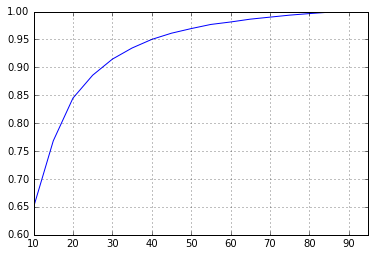

In [121]:
'''
红米手机型号纠正
n_estimators=360,
min_samples_leaf=20,
max_features='auto'
'''
R_step.iloc[3:].plot()
plt.grid()

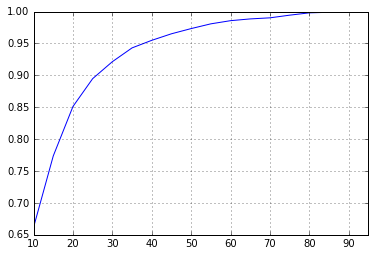

In [87]:
'''
开户渠道
n_estimators=360,
min_samples_leaf=20,
max_features='auto'
'''
R_step.iloc[3:].plot()
plt.grid()



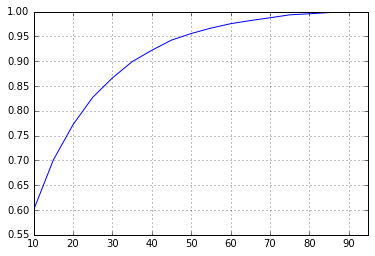

In [289]:
'''
下载渠道
n_estimators=360,
min_samples_leaf=20,
max_features='auto'
'''
R_step.iloc[3:].plot()
plt.grid()


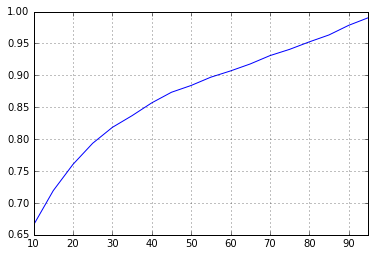

In [292]:
'''
n_estimators=360,
min_samples_leaf=1,
max_features='auto'
'''
R_step.iloc[3:].plot()
plt.grid()

In [297]:
####模型固化
import pickle
rf = pickle.dumps(clf)
model = pickle.loads(rf)
model.predict_proba(train_feat.iloc[test_idx,:-1])
compare2 =DataFrame(prob_result,columns=['0_prob','1_prob']).join(DataFrame(list(train_feat.iloc[test_idx,-1].values),columns=['groundTruth']))
compare2 = compare2.sort_values('1_prob',ascending=False)
recall2 = []
for m in range(10,100,5):
    tmp = compare2.iloc[:int(np.percentile(range(len(compare2)),m))]
    recall2.append((tmp.groundTruth==1).sum()/float((compare2.groundTruth==1).sum()))
    


0.879431776044


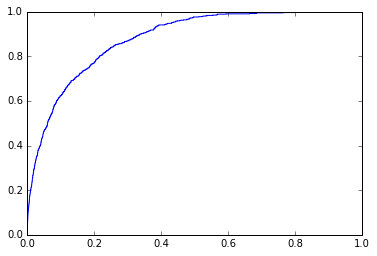

In [314]:
from sklearn.metrics import roc_auc_score,roc_curve,auc
fpr, tpr, thresholds = roc_curve(list(train_feat.iloc[test_idx,-1].values), prob_result[:,1], pos_label=1)
print auc(fpr,tpr)
plt.figure()
plt.plot(fpr,tpr)

In [269]:
###NB 对比
from sklearn.naive_bayes import BernoulliNB
feat_compare = train_feat.drop('screenresolution',axis = 1)
result_cmp = []
for train_idx, test_idx in kf:
    clf=BernoulliNB()
    clf.fit(train_feat.iloc[train_idx,:-1].values,list(train_feat.iloc[train_idx,-1].values))
    prob_result = clf.predict_proba(train_feat.iloc[test_idx,:-1])
    
    ##按概率前20%计算召回率
    compare2 =DataFrame(prob_result,columns=['0_prob','1_prob']).join(DataFrame(list(train_feat.iloc[test_idx,-1].values),columns=['groundTruth']))
    compare2 = compare2.sort_values('1_prob',ascending=False)
    recall2 = []
    for m in range(10,50,5):
        tmp = compare2.iloc[:int(np.percentile(range(len(compare2)),m))]
        recall2.append((tmp.groundTruth==1).sum()/float((compare2.groundTruth==1).sum()))

    result_cmp.append(recall2)
    

In [270]:
DataFrame(result_cmp)

,0,1,2,3,4,5,6,7
0,0.365576,0.462304,0.546230,0.630156,0.694168,0.748222,0.795164,0.839260
1,0.348901,0.450549,0.546703,0.625000,0.693681,0.750000,0.788462,0.837912
2,0.344459,0.467290,0.536716,0.610147,0.675567,0.714286,0.763685,0.806409
3,0.354167,0.469444,0.540278,0.625000,0.691667,0.765278,0.795833,0.843056
4,0.357236,0.481095,0.571056,0.641460,0.700130,0.748370,0.791395,0.837027
